## Transfer Learning with MobileNetV2

MobileNetV2, was designed to provide fast and computationally efficient performance. It's been pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.

At the end of this notebook, you will be able to:

- Create a dataset from a directory
- Preprocess and augment data using the Sequential API
- Adapt a pretrained model to new data and train a classifier using the Functional API and MobileNet
- Fine-tune a classifier's final layers to improve accuracy

In [7]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as tfl
import json
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory #Just set the training set to subset='training' and the validation set to subset='validation' in this function
from keras.layers import RandomFlip, RandomRotation

In [8]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 328 files belonging to 2 classes.
Using 263 files for training.
Found 328 files belonging to 2 classes.
Using 65 files for validation.


2026-02-06 12:36:58.299332: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


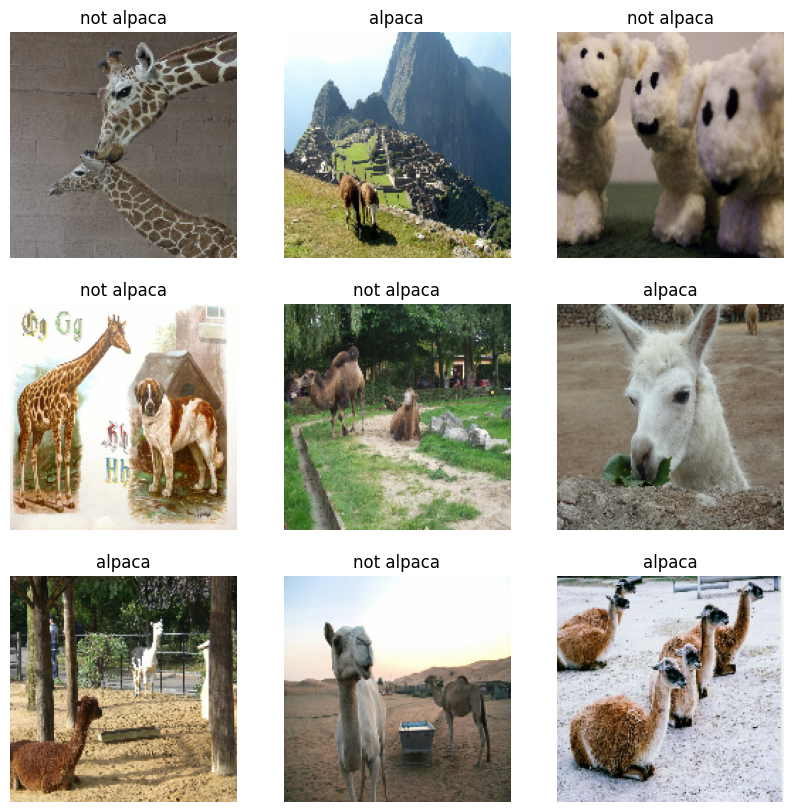

In [10]:
#Now let's take a look at some of the images from the training set:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Preprocess and Augment Training Data 

Using prefetch() prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming ( chunks at a time = little fixed memory), the data doesn't need to fit into memory.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  #Optimizes buffer size
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [12]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

2026-02-06 13:33:36.414063: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


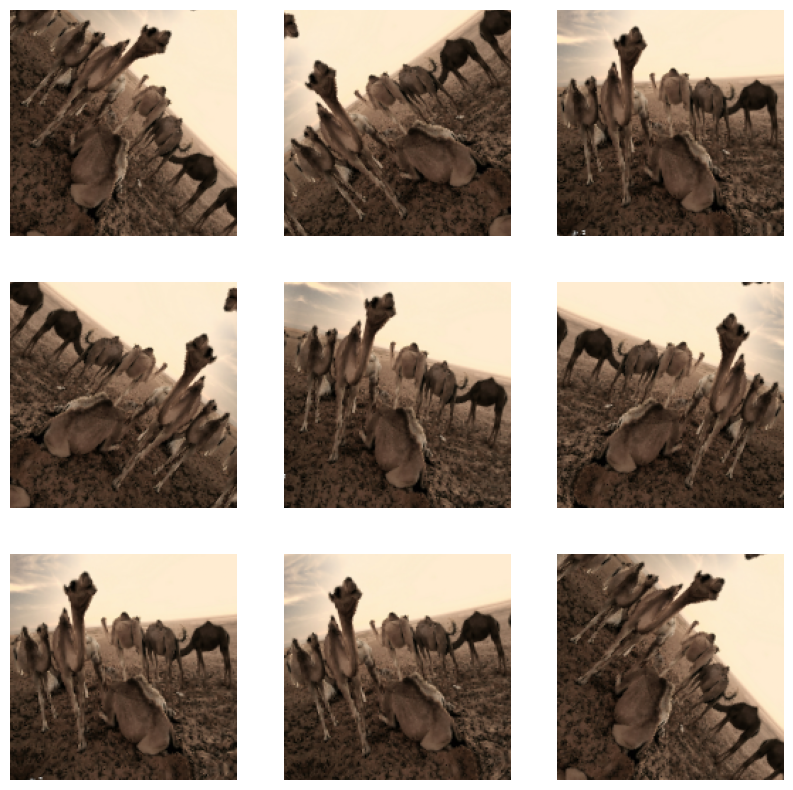

In [14]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

What you should remember:

- When calling image_data_set_from_directory(), specify the train/val subsets and match the seeds to prevent overlap
- Use prefetch() to prevent memory bottlenecks when reading from disk
- Give your model more to learn from with simple data augmentations like rotation and flipping.
- When using a pretrained model, it's best to reuse the weights it was trained on.

## Using MobileNetV2 for Transfer Learning

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep.

The architecture has three defining characteristics:

- Depthwise separable convolutions
- Thin input and output bottlenecks between layers
- Shortcut connections between bottleneck layers

MobileNetV2 uses depthwise separable convolutions as efficient building blocks. Traditional convolutions are often very resource-intensive, and  depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps: 

1. The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.

2. In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is the pointwise convolution, or: **Shape of the depthwise convolution X Number of filters.**

<img src="images/mobilenetv2.png" style="width:650px;height:450px;">

Each block consists of an inverted residual structure with a bottleneck at each end. These bottlenecks encode the intermediate inputs and outputs in a low dimensional space, and prevent non-linearities from destroying important information. 

The shortcut connections, which are similar to the ones in traditional residual networks, serve the same purpose of speeding up training and improving predictions. These connections skip over the intermediate convolutions and connect the bottleneck layers. 

<font color='blue'>

**What you should remember**:

* MobileNetV2's unique features are: 
  * Depthwise separable convolutions that provide lightweight feature filtering and creation
  * Input and output bottlenecks that preserve important information on either end of the block
* Depthwise separable convolutions deal with both spatial and depth (number of channels) dimensions

In [16]:
#Let's try to train your base model using all the layers from the pretrained model.
IMG_SHAPE = IMG_SIZE + (3,)
base_model_path="imagenet_base_model/with_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160.h5"

#By specifying weights='imagenet', the weights are downloaded for ImageNet. But for this notebook, we'll load them locally from this workspace.

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights=base_model_path)

In [17]:
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [19]:
#Note the last 2 layers here. They are the so called top layers, and they are responsible of the classification in the model

nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [22]:
#Lets test out the  MobileNetV2 base model
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [24]:
#The number 32 above refers to the batch size and 1000 above refers to the 1000 classes the model was pretrained on. 

#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1], dtype=int32)>

In [26]:
base_model.trainable = False
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

# Function to decode predictions
def decode_predictions(preds, top=2):
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(class_index[str(i)]) + (pred[i],) for i in top_indices]
        results.append(result)
    return results

with open("imagenet_base_model/imagenet_class_index.json", 'r') as f:
    class_index = json.load(f)
    
decoded_predictions = decode_predictions(pred.numpy(), top=2)
print(decoded_predictions)

[[('n02437312', 'Arabian_camel', 0.7414561), ('n02389026', 'sorrel', 0.006457351)], [('n02437616', 'llama', 0.92788374), ('n02098286', 'West_Highland_white_terrier', 0.0057287207)], [('n02437312', 'Arabian_camel', 0.07579508), ('n01518878', 'ostrich', 0.064679444)], [('n01518878', 'ostrich', 0.9543055), ('n02437312', 'Arabian_camel', 0.0016175571)], [('n01518878', 'ostrich', 0.9294674), ('n02018795', 'bustard', 0.003946679)], [('n02437312', 'Arabian_camel', 0.80912596), ('n02437616', 'llama', 0.015737383)], [('n01883070', 'wombat', 0.22639132), ('n02442845', 'mink', 0.21543026)], [('n02133161', 'American_black_bear', 0.3889175), ('n02492660', 'howler_monkey', 0.10211118)], [('n02454379', 'armadillo', 0.5502785), ('n02137549', 'mongoose', 0.13629502)], [('n01518878', 'ostrich', 0.9267561), ('n02002724', 'black_stork', 0.001776633)], [('n02437616', 'llama', 0.47636956), ('n02437312', 'Arabian_camel', 0.17799476)], [('n02133161', 'American_black_bear', 0.8610769), ('n02134418', 'sloth_bea

The predictions returned by the base model below follow this format: First the class number, then a human-readable label, and last the probability of the image belonging to that class. You'll notice that there are two of these returned for each image in the batch - these the top two probabilities returned for that image.


There's a whole lot of labels here, some of them hilariously wrong, but none of them say "alpaca." This is because MobileNet pretrained over ImageNet doesn't have the correct labels for alpacas, so when you use the full model, all you get is a bunch of incorrectly classified images.

Fortunately, you can delete the top layer, which contains all the classification labels, and create a new classification layer.

## Layer Freezing with the Functional API

You'll see how you can use a pretrained model to modify the classifier task so that it's able to recognize alpacas. You can achieve this in three steps: 

1. Delete the top layer (the classification layer)
    * Set `include_top` in `base_model` as False
2. Add a new classifier layer
    * Train only one layer by freezing the rest of the network
    * As mentioned before, a single neuron is enough to solve a binary classification problem.
3. Freeze the base model and train the newly-created classifier layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

In [27]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
        tf.keras.model
    '''
   
    input_shape = image_shape + (3,) #image_shape = (60, 60), then input_shape = image_shape + (3,) evaluates to (60, 60, 3)
      
    base_model_path = "imagenet_base_model/without_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5"
   
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,           # ← use the actual shape here
        include_top=False,                 # ← Important: remove classification head
        weights=base_model_path            # local weights file (no_top version)
    )
   
    # Freeze the base model by making it non-trainable
    base_model.trainable = False
   
    # Create the input layer (using the correct image shape)
    inputs = tf.keras.Input(shape=input_shape)
   
    # Apply data augmentation to the inputs
    x = data_augmentation(inputs)
   
    # Data preprocessing using the same function MobileNetV2 was trained with
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
   
    # Pass through the frozen base model
    # Set training=False to freeze batch norm statistics (important when base_model is frozen)
    x = base_model(x, training=False)
   
    # Add the new binary classification layers
    # Use global average pooling to summarize spatial info into one value per channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
   
    # Use a prediction layer with one neuron 
    outputs = tf.keras.layers.Dense(1, activation='linear')(x)
   
    model = tf.keras.Model(inputs, outputs)
   
    return model

In [28]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [30]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - accuracy: 0.4639 - loss: 0.8116 - val_accuracy: 0.6769 - val_loss: 0.4983
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.6464 - loss: 0.6404 - val_accuracy: 0.7385 - val_loss: 0.4315
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.7034 - loss: 0.5323 - val_accuracy: 0.7846 - val_loss: 0.3567
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.7148 - loss: 0.5131 - val_accuracy: 0.8615 - val_loss: 0.2996
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.7833 - loss: 0.4592 - val_accuracy: 0.8462 - val_loss: 0.2885


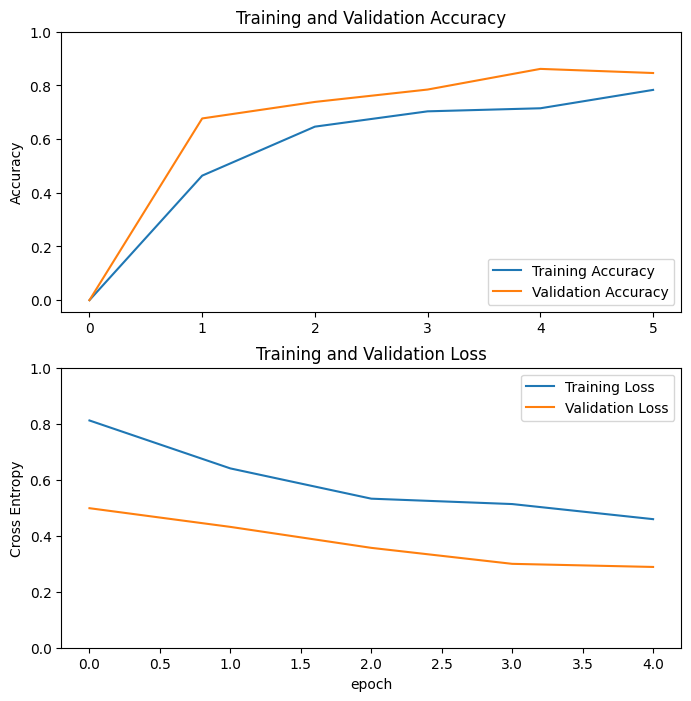

In [32]:
#Plot the training and validation accuracy:

acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [34]:
#The results are ok, but could be better. Next, try some fine-tuning.

class_names

['alpaca', 'not alpaca']

## Fine-tuning the Model

In transfer learning, the way you achieve this is by unfreezing the layers at the end of the network, and then re-training your model on the final layers with a very low learning rate. Adapting your learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.To achieve this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.

In [41]:
for i, layer in enumerate(model2.layers):
    print(f"Index {i}: {layer.__class__.__name__}  -  name: {layer.name}")

Index 0: InputLayer  -  name: input_layer_3
Index 1: Sequential  -  name: sequential_1
Index 2: Functional  -  name: mobilenetv2_1.00_160
Index 3: GlobalAveragePooling2D  -  name: global_average_pooling2d_1
Index 4: Dropout  -  name: dropout
Index 5: Dense  -  name: dense


In [42]:
base_model = model2.layers[2]
base_model.trainable = True

In [40]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [44]:
# Lets Fine tune at Layer 120 onwards
fine_tune_at = 120


# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False     # ← use False (not None)

# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1 * base_learning_rate)

# Use accuracy as evaluation metric
metrics = ['accuracy']


In [45]:
model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [46]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

""" 
history is the object returned from the first.fit() call.history.epoch is a list of the epoch numbers that were actually run during that first training phase.
#initial_epochs = 5, then history.epoch == [0, 1, 2, 3, 4], So history.epoch[-1] == 4 (the last epoch that was completed)
Keras begins counting epochs from initial_epoch (not from 0 again).Result → the epochs in the fine-tuning phase are numbered 5, 6, 7, 8, 9
"""

Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 314ms/step - accuracy: 0.7985 - loss: 0.4382 - val_accuracy: 0.9385 - val_loss: 0.1806
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.8631 - loss: 0.2909 - val_accuracy: 0.9538 - val_loss: 0.1199
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.9049 - loss: 0.2160 - val_accuracy: 0.9692 - val_loss: 0.0849
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.8897 - loss: 0.2027 - val_accuracy: 0.9692 - val_loss: 0.0716
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.9506 - loss: 0.1254 - val_accuracy: 1.0000 - val_loss: 0.0506
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.9544 - loss: 0.1329 - val_accuracy: 1.0000 - val_loss: 0.0381


In [47]:
#Quite an improvement! A little fine-tuning can really go a long way.

In [48]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

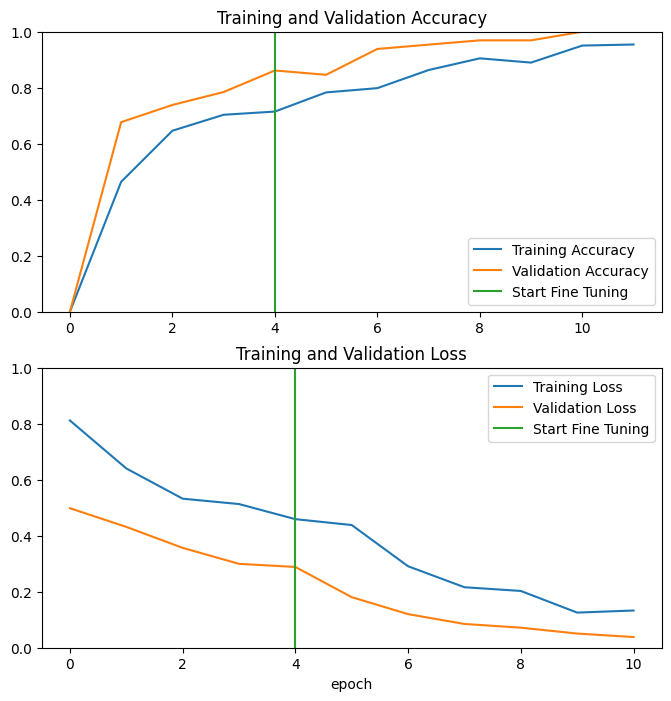

In [49]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**What you should remember**:

* To adapt the classifier to new data: Delete the top layer, add a new classification layer, and train only on that layer
* When freezing layers, avoid keeping track of statistics (like in the batch normalization layer)
* Fine-tune the final layers of your model to capture high-level details near the end of the network and potentially improve accuracy 